In [2]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 400
plt.rcParams['axes.grid'] = True
plt.rcParams['image.aspect'] = 0.8

import numpy as np
import casadi as ca
from helper_fns import yaml_load


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
from robot import Robot
from helper_fns import spawn_models
mpc_params = yaml_load('config/mpc_params.yaml')
ipopt_options = yaml_load('config/ipopt_options.yaml')

_, robots, contacts = spawn_models(robot_path = "config/franka.yaml",
                                   attr_path  = "config/attrs.yaml", 
                                   contact_path = "config/contact_test.yaml",
                                   sym_vars = [])
q0 = np.ones(7)
dq0 = 0.05*np.ones(7)

params = {'q': q0,
          'dq': dq0,
          'belief_free':1.0,
          'belief_point':0.0,
          'imp_stiff':400*ca.DM.ones(3),}

In [14]:
from robot import Robot
from contact import Contact
from impedance_controller import ImpedanceController
from mpc import MPC
par = {'pos': [0, 0, 0.0],
       'stiff': [0, 0, 3e4],
        'rest':[0, 0, 0.7]}
attrs = yaml_load('config/attrs.yaml')
attrs = {k:attrs[k] for k in ['lb', 'ub']}
imp = ImpedanceController(input_vars = ['imp_rest'],
                          attrs = attrs)
rob = Robot('config/franka.urdf', subsys = [], ctrl = imp, attrs = attrs, visc_fric = 100)

mpc_params= yaml_load('config/mpc_params.yaml')
mpc = MPC(robots={'free':rob}, mpc_params = mpc_params, ipopt_options = ipopt_options)
mpc.icem_init()
M_inv = rob.inv_mass_fn(ca.DM.zeros(7))

# for H=5, dt=0.05
# 3.2 ms for 80 samples, symbolic mass
# 1.8 ms for 80 samples, numerical mass
%timeit mpc.robots['free'].rollout(np.zeros(14), np.zeros((3,mpc_params['num_samples']*mpc_params['H'])), M_inv, np.ones(3))
# 3.4 ms for 80 samples w/ ca.DM inputs, 3.9 with numpy inputs, all symbolic mass
# 1.8 ms for 80 smaples, numerical mass
%timeit mpc.robots['free'].rollout_map(ca.DM.zeros((14,1)), ca.DM.ones((3,mpc_params['num_samples']*mpc_params['H'])), M_inv, ca.DM.zeros(3))
#res = mpc.robots['free'].step_vec(ca.DM.zeros((14)), 2*ca.DM.ones((3)), M_inv, 100*ca.DM.ones(3))
#res = mpc.robots['free'].rollout(ca.DM.zeros((14,1)), 1*ca.DM.ones((3,mpc_params['H'])), M_inv, 100*ca.DM.ones(3))
res = mpc.robots['free'].rollout(ca.DM.zeros((14)), np.random.randn(3,mpc_params['num_samples']*mpc_params['H']), M_inv, 100*ca.DM.ones(3))
#print(res)

3.68 ms ± 15.6 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
1.34 ms ± 9.8 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [30]:
# solve time, mpc 
import time
from mpc import MPC

params = {'q': q0,
          'dq': dq0,
          'belief_free':0.0,
          'belief_point':1.0,
          'imp_stiff':400*ca.DM.ones(3),}


mpc_params= yaml_load('config/mpc_params.yaml')
ipopt_options = yaml_load('config/ipopt_options.yaml')

mpc = MPC(robots, mpc_params = mpc_params, ipopt_options = ipopt_options)
N = 20
times = []
costs = []
for _ in range(N):
    params['q'] = 0.05*np.random.randn(7) # perturb initial state
    tic = time.perf_counter()
    cost, _ = mpc.solve(params)
    times.append(time.perf_counter()-tic)
    costs.append(np.squeeze(cost.full()))
print(f'Cold start time:  {times[0]} sec')
print(f'Cold start rate:  {1/times[0]} Hz')
print(f'Warm start rate: {1/np.mean(times[1:])} Hz')
print(f'Cost mean: {np.mean(costs)}, cov: {np.cov(costs)}')
mpc_cost_mean = np.mean(costs)
mpc_cost_std = np.cov(costs)

Adding contact setpoint cost for contact_1/F
Cold start time:  0.7481383580015972 sec
Cold start rate:  1.336651154568745 Hz
Warm start rate: 64.21397927455789 Hz
Cost mean: 4.998702620280836, cov: 1.576838845692303e-05


In [31]:
# solve time, cem 
import time
from mpc import MPC


mpc_params= yaml_load('config/mpc_params.yaml')
iters = [2,3,5,10,20,30,40,50,60,70,80]
iter_times = []
iter_cost_mean = []
iter_cost_std = []
for n_iter in iters:
    times = []
    costs = []
    mpc_params['num_iter'] = n_iter
    mpc = MPC(robots, mpc_params = mpc_params, ipopt_options = ipopt_options)
    for _ in range(N):
        mpc.icem_init()
        params['q'] = 0.005*np.random.randn(7) # perturb initial state
        tic = time.perf_counter()
        cost, _ = mpc.icem_solve(params)
        times.append(time.perf_counter()-tic)
        costs.append(np.squeeze(cost.full()))
    iter_times.append(1/np.mean(times[1:]))
    iter_cost_mean.append(np.mean(costs))
    iter_cost_std.append(np.std(costs))

print(f'Cold start time:  {times[0]} sec')
print(f'Cold start rate:  {1/times[0]} Hz')
print(f'Warm start rate: {1/np.mean(times[1:])} Hz')
print(f'Cost mean: {np.mean(costs)}, cov: {np.std(costs)}')

Adding contact setpoint cost for contact_1/F
Adding contact setpoint cost for contact_1/F
Adding contact setpoint cost for contact_1/F
Adding contact setpoint cost for contact_1/F
Adding contact setpoint cost for contact_1/F
Adding contact setpoint cost for contact_1/F
Adding contact setpoint cost for contact_1/F
Adding contact setpoint cost for contact_1/F
Adding contact setpoint cost for contact_1/F
Adding contact setpoint cost for contact_1/F
Adding contact setpoint cost for contact_1/F
Cold start time:  0.5221594689646736 sec
Cold start rate:  1.915123749422333 Hz
Warm start rate: 1.3848481513071038 Hz
Cost mean: 6.0656372766485465, cov: 0.11016041873058495


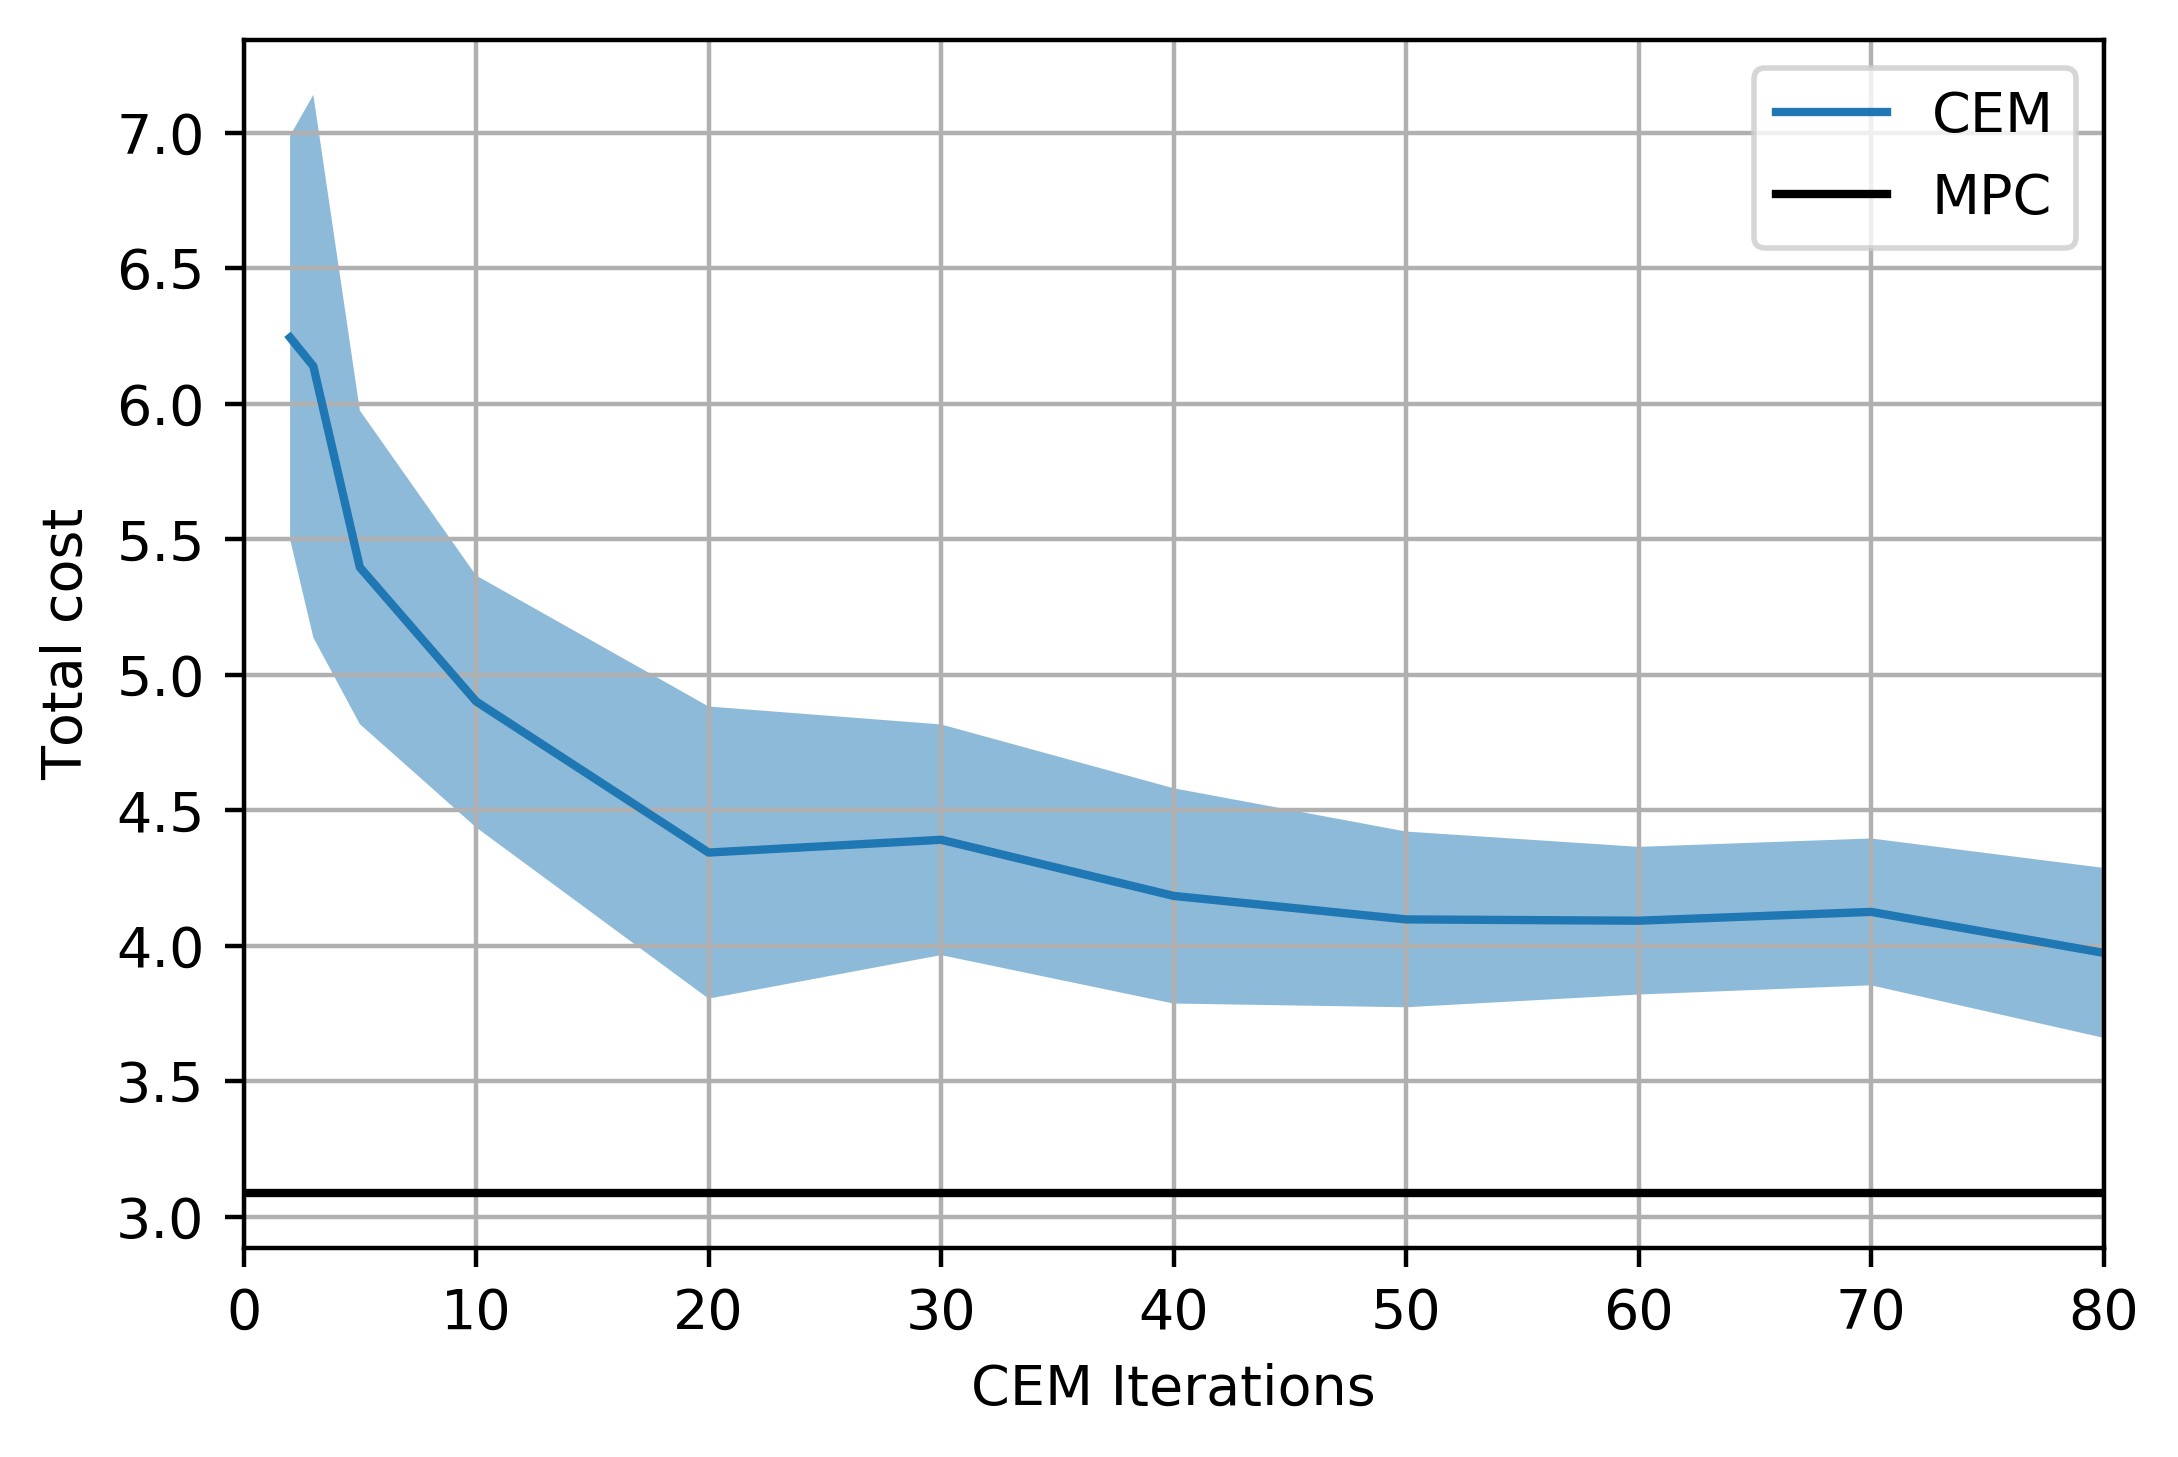

In [19]:
plt.plot(iters, iter_cost_mean, label='CEM')
mu = np.array(iter_cost_mean)
sig = np.array(iter_cost_std)
plt.fill_between(iters, mu-sig, mu+sig, alpha=0.5)

plt.axhline(y=mpc_cost_mean, color='k', label='MPC')
plt.legend()
plt.xlim(0,iters[-1])
plt.xlabel('CEM Iterations')
plt.ylabel('Total cost')
plt.savefig('mpc_vs_cem_num_iter.pdf')

In [32]:
from robot import Robot
from helper_fns import spawn_models
from mpc import MPC

mpc_params = yaml_load('config/mpc_params.yaml')
ipopt_options = yaml_load('config/ipopt_options.yaml')

_, robots, contacts = spawn_models(robot_path = "config/franka.yaml",
                                   attr_path  = "config/attrs.yaml", 
                                   contact_path = "config/contact_test.yaml",
                                   sym_vars = [])
mpc_params = yaml_load('config/mpc_params.yaml')
mpc = MPC(robots, mpc_params=mpc_params, ipopt_options = ipopt_options)
params = {'q': ca.DM.zeros(7),
          'dq': ca.DM.zeros(7),
          'belief_free':0.0, 
          'belief_point':1.0,
          'imp_stiff':400*ca.DM.ones(3),}
cost, res = mpc.solve(params)
traj = robots['point'].get_ext_state(res)
print(cost)
#print(traj['imp_rest'])
p_mpc = np.squeeze(np.array(traj['p']))
u_mpc = np.squeeze(np.array(traj['imp_rest']))


Adding contact setpoint cost for contact_1/F
5.10203


In [33]:
mpc_params = yaml_load('config/mpc_params.yaml')
mpc = MPC(robots, mpc_params=mpc_params, ipopt_options = ipopt_options)
mpc.icem_init()
cost, res = mpc.icem_solve(params)

traj_cem = robots['point'].get_ext_state(res)
p_cem = np.squeeze(np.array(traj_cem['p']))
u_cem = np.squeeze(np.array(traj_cem['imp_rest']))
print(cost)

Adding contact setpoint cost for contact_1/F
5.96187


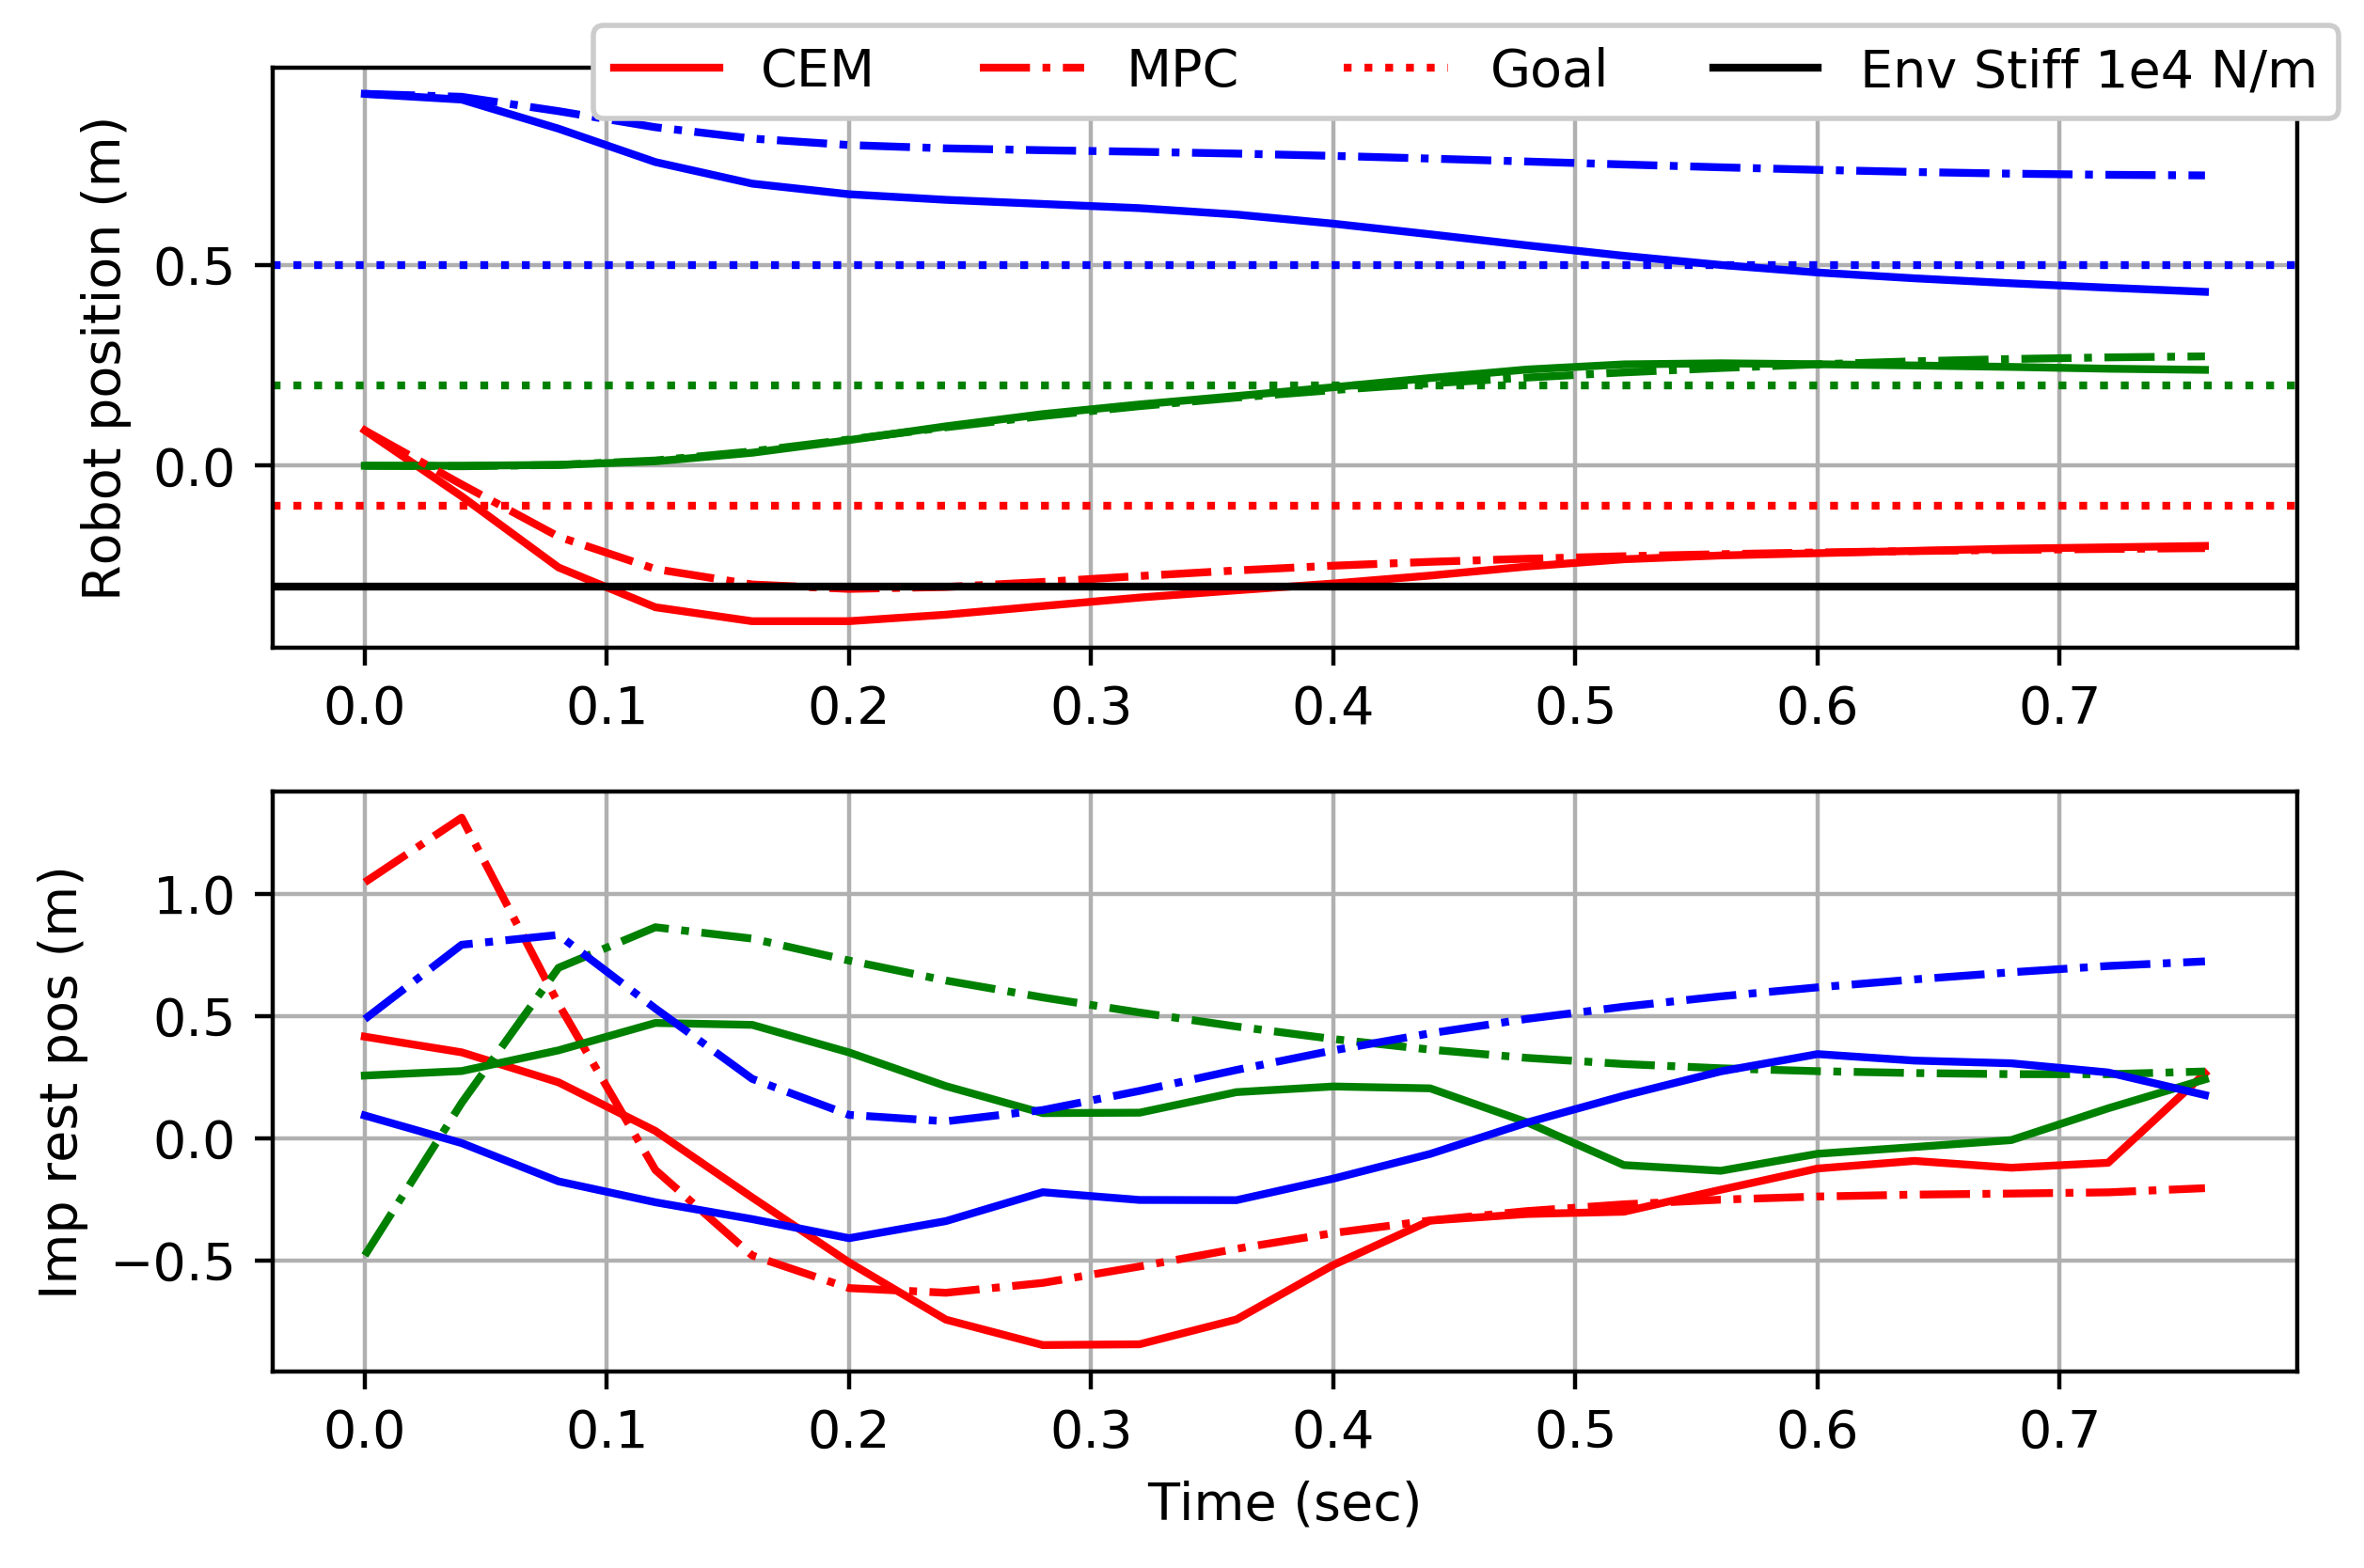

In [34]:
import matplotlib.pyplot as plt
import numpy as np



t = [mpc_params['dt']*step for step in range(mpc_params['H'])]
fig, axs = plt.subplots(2, 1)
cols = ['r', 'g', 'b']
axs[0].plot(t, p_cem[0,:], label='CEM', color='r')
axs[0].plot(t, p_cem[1,:], color='g')
axs[0].plot(t, p_cem[2,:], color='b')
axs[0].plot(t, p_mpc[0,:], label='MPC', color='r', linestyle='-.')
axs[0].plot(t, p_mpc[1,:], color='g', linestyle='-.')
axs[0].plot(t, p_mpc[2,:], color='b', linestyle='-.')


cols = ['r', 'g', 'b']
for i in range(3):
    col = cols.pop(0)
    axs[1].plot(t, u_cem[i,:], color=col)
    axs[1].plot(t, u_mpc[i,:], color=col, linestyle='-.')

    
axs[0].axhline(y=mpc_params['des_pose'][0], color='r', label='Goal',linestyle=':')
axs[0].axhline(y=mpc_params['des_pose'][1], color='g', linestyle=':')
axs[0].axhline(y=mpc_params['des_pose'][2], color='b', linestyle=':')

axs[0].axhline(y=-0.3, color='k', label = 'Env Stiff 1e4 N/m')

    
fig.legend(ncol=4, framealpha=1.0)
plt.tight_layout()
#plt.xlim([0, t[-1]])
axs[0].set_ylabel('Robot position (m)')
axs[1].set_ylabel('Imp rest pos (m)')
axs[1].set_xlabel('Time (sec)')
plt.savefig('mpc_vs_cem_stiff.pdf')

In [343]:
samps = np.ones((3,70,10))
news = np.ones((3,10,10))
bigsamps = np.ones((3,80,10))
%timeit np.append(samps, news)
%timeit bigsamps[:,:10,:] = news
%timeit samps.clip(0,1, out=samps)
%timeit samps.reshape(3,-1)
print(samps.shape)

3.66 µs ± 431 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)
622 ns ± 29.7 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)
12.4 µs ± 945 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)
170 ns ± 10.8 ns per loop (mean ± std. dev. of 7 runs, 10,000,000 loops each)
(3, 70, 10)
